In [1]:
import numpy as np

from keras.preprocessing import sequence
import keras.models as km
import keras.layers as kl
import keras.constraints as kc
from keras.datasets import imdb

import matplotlib.pyplot as plt
%matplotlib inline

import ipywidgets as ipw

Using TensorFlow backend.
/home/ergodlws/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Wir definieren zunächst wieder globale Parameter.

`num_words` bezeichnet hier die Größe unseres Vokabulars. In diesem Falle nehmen wir nur die 20.000 meist vorkommenden Worte. Seltenere Worte werden durch einen Platzhalter für ein fehlendes Wort ersetzt.

`maxlen` bezeichnet die maximale Länge der Eingabesequenzen. Kürze Sequenzen werden mit einem Platzhalter aufgefüllt, länge Sequenzen beschnitten.

In [2]:
num_words = 20000
maxlen = 100
batch_size = 32

Wir laden den IMBD Sentiment Datensatz. Ziel ist es hier, anhand des Textes zu erkennen, ob es sich um einen positiven oder negativen Kommentar zu einem Film handelt.

In [3]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words, index_from=2)

17465344/17464789 [==============================] - 3s 0us/step


Der Datensatz enthält jeweils 25.000 Trainings- und Testbeispiele. Diese sind bereits in Worte aufgeteilt und die Worte werde als Integer dargestellt. Um die Texte lesbar zu machen, laden wir noch die Tabelle, welche Integer wieder auf Worte projiziert.

In [4]:
print(x_train[0])

[1, 13, 21, 15, 42, 529, 972, 1621, 1384, 64, 457, 4467, 65, 3940, 3, 172, 35, 255, 4, 24, 99, 42, 837, 111, 49, 669, 2, 8, 34, 479, 283, 4, 149, 3, 171, 111, 166, 2, 335, 384, 38, 3, 171, 4535, 1110, 16, 545, 37, 12, 446, 3, 191, 49, 15, 5, 146, 2024, 18, 13, 21, 3, 1919, 4612, 468, 3, 21, 70, 86, 11, 15, 42, 529, 37, 75, 14, 12, 1246, 3, 21, 16, 514, 16, 11, 15, 625, 17, 19192, 4, 61, 385, 11, 7, 315, 7, 105, 4, 3, 2222, 5243, 15, 479, 65, 3784, 32, 3, 129, 11, 15, 37, 618, 4, 24, 123, 50, 35, 134, 47, 24, 1414, 32, 5, 21, 11, 214, 27, 76, 51, 4, 13, 406, 15, 81, 10310, 7, 3, 106, 116, 5951, 14, 255, 3, 2, 6, 3765, 4, 722, 35, 70, 42, 529, 475, 25, 399, 316, 45, 6, 3, 12117, 1028, 12, 103, 87, 3, 380, 14, 296, 97, 31, 2070, 55, 25, 140, 5, 193, 7485, 17, 3, 225, 21, 20, 133, 475, 25, 479, 4, 143, 29, 5534, 17, 50, 35, 27, 223, 91, 24, 103, 3, 225, 64, 15, 37, 1333, 87, 11, 15, 282, 4, 15, 4471, 112, 102, 31, 14, 15, 5344, 18, 177, 31]


Wir laden zunächst die Tabelle mit der Abbildung von Wort auf Index und bilden dann die inverse Tabelle. Dabei müssen wir beachten, dass bestimmte Indices nicht für worte, sondern für bestimmte Steuerungszeichen stehen:

- 0 wird verwendet um "padding" darzustellen. Sequenzen kürzer als `maxlen` werden am Ende mit Nullen aufgefüllt.
- 1 stellt markiert den Anfang eines Satzes
- 2 wird für Out Of Vocabulary (OOV) Worte verwendet, also solche Worte, die nicht unter den top `num_words` Worten waren.

In [5]:
word2index = imdb.get_word_index()
index2word = {i + 2: w for w, i in word2index.items()}

index2word[0] = ''
index2word[1] = '<START>'
index2word[2] = '<OOV>'

1646592/1641221 [==============================] - 1s 1us/step


Mit dieser Tabelle lassen sich nun die Texte wieder umwandeln.

In [6]:
def features_to_text(features):
    return " ".join(index2word[i] for i in features)

print(features_to_text(x_train[0]))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <OOV> is an amazing actor and now the same being director <OOV> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <OOV> of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be p

Wir formatieren nun die Sequenzen so, dass sie alle die gleiche Länge haben.

In [9]:
x_train_pad = sequence.pad_sequences(x_train, maxlen=maxlen, padding='post', truncating='post')
x_test_pad = sequence.pad_sequences(x_test, maxlen=maxlen, padding='post', truncating='post')

y_train = np.array(y_train)
y_test = np.array(y_test)

In [10]:
print(features_to_text(x_train_pad[0]))

<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <OOV> is an amazing actor and now the same being director <OOV> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was


Wir wollen zunächst ein einfaches LSTM-Modell implementieren. Sprachmodelle beginnen typischerweise mit einem Embedding-Layer, welches die Liste von Indices in Vektoren umwandelt. Diese Sequenz von Vektoren wird dann als Eingabe für das LSTM-Layer verwendet. Als Ausgabe des LSTM-Layer erhalten wir den finalen interenen Zustand des Layers, den wir als Features für eine binäre logistische Regression verwenden.

Zwei Besonderheiten sind hier zu beobachten: Zum einen verwenden wir eine bestimmte Implementierung des LSTM-Layers, welche auf Nvidia-GPUs besonder performant ist (CuDNNLSTM). Zum Anderen verwenden wir als Regularisierung hinter dem Embedding-Layer ein SpatialDropout1D-Layer. Dies sorgt dafür, dass in jedem Schritt in der Wort-Sequenz die gleichen Werte weggelassen werden.

In [11]:
sequence_input = kl.Input(shape=(maxlen,))

sequence_embeddings = kl.Embedding(num_words + 3, 32)
lstm_layer = kl.CuDNNLSTM(32)
clf_layer = kl.Dense(1, activation='sigmoid')

output = sequence_embeddings(sequence_input)
output = kl.SpatialDropout1D(0.5)(output)
output = lstm_layer(output)
output = kl.Dropout(0.5)(output)
output = clf_layer(output)

simple_model = km.Model(inputs=sequence_input, outputs=output)

Aus der Summary wird ersichtlich, dass der großteil der Parameter in dem Embedding-Layer steckt.

In [12]:
simple_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 32)           640096    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 32)           0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 32)                8448      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 648,577
Trainable params: 648,577
Non-trainable params: 0
_________________________________________________________________


LSTM-Netzwerke sind notorisch dafür, schwer optimierbar zu sein. Wir verwenden in diesem Fall den Adadelta-Optimizer.

In [13]:
simple_model.compile('adadelta', 'binary_crossentropy', metrics=['accuracy'])

history_simple = simple_model.fit(
    x_train_pad, y_train,
    batch_size=batch_size,
    epochs=10,
    shuffle=True,
    validation_data=[x_test_pad, y_test])

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 26s 1ms/step - loss: 0.6911 - acc: 0.5216 - val_loss: 0.7241 - val_acc: 0.5378
Epoch 2/10
25000/25000 [==============================] - 18s 714us/step - loss: 0.5912 - acc: 0.6967 - val_loss: 0.5116 - val_acc: 0.7554
Epoch 3/10
25000/25000 [==============================] - 18s 727us/step - loss: 0.4735 - acc: 0.7845 - val_loss: 0.4398 - val_acc: 0.7963
Epoch 4/10
25000/25000 [==============================] - 18s 723us/step - loss: 0.4170 - acc: 0.8166 - val_loss: 0.4332 - val_acc: 0.8018
Epoch 5/10
25000/25000 [==============================] - 18s 719us/step - loss: 0.3851 - acc: 0.8347 - val_loss: 0.4234 - val_acc: 0.8048
Epoch 6/10
25000/25000 [==============================] - 18s 719us/step - loss: 0.3625 - acc: 0.8464 - val_loss: 0.4044 - val_acc: 0.8191
Epoch 7/10
25000/25000 [==============================] - 17s 696us/step - loss: 0.3398 - acc: 0.8594 - val_loss: 0.41

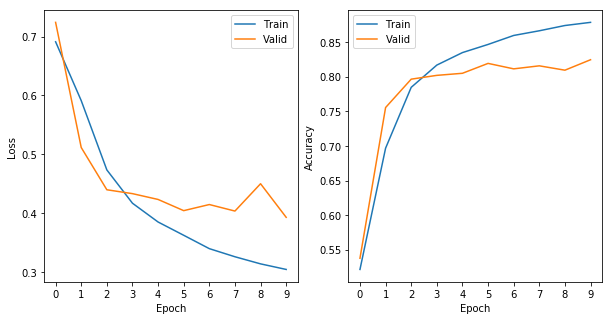

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(history_simple.epoch, history_simple.history['loss'], label='Train')
ax1.plot(history_simple.epoch, history_simple.history['val_loss'], label='Valid')
ax1.set_ylabel('Loss')

ax2.plot(history_simple.epoch, history_simple.history['acc'], label='Train')
ax2.plot(history_simple.epoch, history_simple.history['val_acc'], label='Valid')
ax2.set_ylabel('Accuracy')

for ax in (ax1, ax2):
    ax.set_xticks(history_simple.epoch)
    ax.set_xlabel('Epoch')
    ax.legend()

None

Um zu visualisieren, was das LSTM tatsächlich gelernt hat, können wir uns den Verlauf des internen Zustands über die Sequenz ansehen. Dafür konfigurieren wir das LSTM zuerst so, dass es den internen Zustand zu jedem Zeitpunkt zurückgibt und erstellen ein Keras-Modell, welches den internen Zustand des LSTMs zurück gibt. In dieser Visualisierung kann man gut erkennen, dass ein großteil des LSTM-Zustands von positiven oder negativen Wörtern dominiert wird.

In [15]:
lstm_layer.return_sequences = True

state_out = sequence_embeddings(sequence_input)
state_out = lstm_layer(state_out)

state_model = km.Model(inputs=sequence_input, outputs=state_out)

lstm_layer.return_sequences = False

In [16]:
def normalize(x):
    y = x - x.mean(0)
    y /= y.std(0)
    return y

In [17]:
def plot_hidden_state(sample_idx):
    
    img, = state_model.predict(x_train_pad[sample_idx:sample_idx+1])
    
    fig, ax = plt.subplots(1,1, figsize=(5, 17))

    mappable = ax.imshow(normalize(img), cmap='RdBu_r', aspect='auto')

    ax.set_yticks(np.arange(100))
    ax.set_yticklabels(features_to_text(x_test_pad[sample_idx]).split(' '))

In [18]:
ipw.interact(plot_hidden_state, sample_idx=ipw.IntSlider(min=0, max=25000, continuous_update=False))

None

A Jupyter Widget